# 1. Classification

In [136]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.7/dist-packages (0.8.0)


In [20]:
import os
os.chdir('/content/drive/MyDrive/Data Science/Projects/Comparison-of-Machine-Learning-Prediction-Models-master/classification/')

import sys
sys.path.append('../Utils')
from pre_processing import *
data_path = 'dataset/'
image_path = 'image/'



In [3]:
import random
import scipy
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import scikitplot as skplt
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import label_binarize
from sklearn import datasets 
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import *
from sklearn.metrics import *

from sklearn.ensemble import GradientBoostingClassifier



## Plot ROC and PR curves

In [5]:
def plot_all(X_test, y_test, all_clfs, clf_names, file_name):
    plt.figure(figsize=(16,8))
    plt.suptitle("Dataset: %s"%file_name, size=16)
    plt.subplot(121)
    roc_scores = plot_roc_curve(X_test, y_test, all_clfs, clf_names)
    plt.subplot(122)
    pr_scores = plot_pr_curve(X_test, y_test, all_clfs, clf_names)
    plt.savefig(image_path+file.split('.')[0]+'-roc_pr')
    plt.show()
    clf_scores = clf_score(X_test, y_test, all_clfs, clf_names, file_name)
    return roc_scores, pr_scores, clf_scores

#accuracy, recall and F1 score

def clf_score(X_test, y_test, all_clfs, clf_names, target_name):
      
  #clf_scores = dict()

  clf_scores = pd.DataFrame(columns=['target', 'Model','Accuracy', 'AUC','Recall', 'Precision', 'F1'])

  for clf, clf_name in zip(all_clfs, clf_names):
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)
    fpr0, tpr0, thresholds = roc_curve(y_test, y_score[:, 1])
    
    roc_auc0 = sklearn.metrics.auc(fpr0, tpr0)
    accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
    recall = sklearn.metrics.recall_score(y_test, y_pred)
    precision = sklearn.metrics.precision_score(y_test, y_pred)
    f1 = sklearn.metrics.f1_score(y_test, y_pred)
    temp = [target_name, clf_name, accuracy, roc_auc0, recall, precision, f1]

    a_series = pd.Series(temp, index = clf_scores.columns) 
    clf_scores = clf_scores.append(a_series, ignore_index = True)
    print(target_name, clf_name)
    print('Precision score %s' % precision)
    print('Recall score %s' % recall)
    print('F1-score score %s' % f1)
    print('Accuracy score %s' % accuracy)
  return clf_scores

#plot tools
def plot_roc_curve(X_test, y_test, all_clfs, clf_names):
    roc_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]

    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes 
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, preds)
            roc_auc = sklearn.metrics.auc(fpr, tpr)
            roc_scores[clf_name] = roc_auc
            plt.plot(fpr, tpr, 'b', label = '%s (AUC = %0.3f)' % (clf_name,roc_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')         
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            for i in range(n_classes):
                fpr[i], tpr[i], _ = sklearn.metrics.roc_curve(y_test[:,i],y_score[:,i])
                roc_auc[i] = sklearn.metrics.auc(fpr[i], tpr[i])
            # Compute micro-average ROC curve and ROC area
            fpr["micro"], tpr["micro"], _ = sklearn.metrics.roc_curve(y_test.ravel(),y_score.ravel())
            roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
            roc_scores[clf_name] = roc_auc["micro"]
            plt.plot(fpr["micro"], tpr["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,roc_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower right')        
    return roc_scores

def plot_pr_curve(X_test, y_test, all_clfs, clf_names):
    pr_scores = dict()
#     plt.figure(figsize=(10,8))
    plt.title('Precision-Recall Curve')
    plt.plot([0, 1], [1, 0],'r--')
    plt.xlim([0, 1.0])
    plt.ylim([0, 1.02])
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    np.random.seed(0)
    y_test = label_binarize(y_test, classes=np.unique(y_test))
    n_classes = y_test.shape[1]
    
    for clf, clf_name in zip(all_clfs, clf_names):
        #two classes
        if n_classes <= 2:
            probs = clf.predict_proba(X_test)
            preds = probs[:,1]
            precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, preds)
            pr_auc = sklearn.metrics.auc(recall, precision)
            pr_scores[clf_name] = pr_auc
            plt.plot(recall, precision, 'b', label = '%s (AUC = %0.3f)' % (clf_name,pr_auc), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
        #multi classes
        else:
            y_score = clf.predict_proba(X_test)
            # Compute ROC curve and ROC area for each class
            precision = dict()
            recall = dict()
            pr_auc = dict()
            for i in range(n_classes):
                precision[i], recall[i], _ = sklearn.metrics.precision_recall_curve(y_test[:,i],y_score[:,i])
                pr_auc[i] = sklearn.metrics.auc(recall[i], precision[i])
            # Compute micro-average ROC curve and ROC area
            precision["micro"], recall["micro"], _ = sklearn.metrics.precision_recall_curve(y_test.ravel(),y_score.ravel())
            pr_auc["micro"] = sklearn.metrics.auc(recall["micro"], precision["micro"])  
            pr_scores[clf_name] = pr_auc["micro"]
            plt.plot(recall["micro"], precision["micro"], 'b', label = '%s (Micro AUC = %0.3f)' % 
                     (clf_name,pr_auc["micro"]), c=np.random.rand(3,))
            plt.legend(loc = 'lower left')
    return pr_scores

## Pre-porcessing

import from Utils folder

## Models

In [6]:
# classifiers
def train_KNN(X_train, y_train):
    print('Training KNN ...')
    knn = KNeighborsClassifier()
#     scoring = ['roc_auc']
    param_distributions = {
        'n_neighbors' : scipy.stats.randint(1,20)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        knn,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_SVM(X_train, y_train):
    print('Training SVM ...')
    svm = SVC(kernel='rbf', probability=True, cache_size=3000, random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 100.),
        'gamma' : scipy.stats.reciprocal(0.01, 10.),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        svm,param_distributions,n_iter=20,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_DecisionTree(X_train, y_train):
    print('Training DecisionTree ...')
    tree = DecisionTreeClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        tree,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_RandomForest(X_train, y_train):
    print('Training RandomForest ...')
    forest = RandomForestClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'max_depth' : scipy.stats.randint(10,100),
        'n_estimators' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        forest,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_

def train_AdaBoost(X_train, y_train):
    print('Training AdaBoost ...')
    boost = AdaBoostClassifier(random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'learning_rate' : scipy.stats.uniform(0.75, 1.25),
        'n_estimators' : scipy.stats.randint(40,70)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        boost,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_    

def train_LogisticRegression(X_train, y_train):
    print('Training LogisticRegression ...')
    lr = LogisticRegression(solver='liblinear', multi_class='auto', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'C' : scipy.stats.reciprocal(1.0, 1000.),
        'max_iter' : scipy.stats.randint(100,1000)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        lr,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_GaussianNaiveBayes(X_train, y_train):
    print('Training GaussianNaiveBayes ...')
    gaussian = GaussianNB()
#     scoring = ['roc_auc']
    param_distributions = {
        'var_smoothing' : scipy.stats.uniform(1e-10, 1e-9),
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        gaussian,param_distributions,n_iter=30,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_NeuralNetwork(X_train, y_train):
    print('Training NeuralNetwork ...')
    nn = MLPClassifier(solver='adam', random_state=0)
#     scoring = ['roc_auc']
    param_distributions = {
        'hidden_layer_sizes' : [(100,50,10)],
        'learning_rate_init' : scipy.stats.uniform(0.001, 0.005),
        'max_iter' : scipy.stats.randint(200,500)
    }
    randcv = sklearn.model_selection.RandomizedSearchCV(
        nn,param_distributions,n_iter=10,cv=3,n_jobs=-1,random_state=0)
    randcv.fit(X_train, y_train)
    return randcv.best_estimator_ 

def train_GradientBoostingClassifier(X_train, y_train):
    print('Training GradientBoosting ...')
    randcv = GradientBoostingClassifier(
        n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    
    randcv.fit(X_train, y_train)
    return randcv




In [58]:
def run_all_clfs(X_train, y_train, X_test, y_test):
    all_clfs = []
    clf_names = []



    # clf1 = train_RandomForest(X_train, y_train)
    # all_clfs.append(clf1)
    # clf_names.append('Random Forest')
    # print('clf1', clf1)

    clf1 = train_KNN(X_train, y_train)
    all_clfs.append(clf1)
    clf_names.append('KNN')
    print('clf1', clf1)

    

    clf2 = train_SVM(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('SVM')
    print('clf2', clf2)

    clf3 = train_DecisionTree(X_train, y_train)
    all_clfs.append(clf3)
    clf_names.append('Decision Tree')
    print('clf3', clf3)

    clf4 = train_RandomForest(X_train, y_train)
    all_clfs.append(clf4)
    clf_names.append('Random Forest')
    print('clf4', clf4)

    clf5 = train_AdaBoost(X_train, y_train)
    all_clfs.append(clf5)
    clf_names.append('AdaBoost')
    print('clf5', clf5)

    clf6 = train_LogisticRegression(X_train, y_train)
    all_clfs.append(clf6)
    clf_names.append('Logistic regression')
    print('clf6', clf6)

    clf7 = train_GaussianNaiveBayes(X_train, y_train)
    all_clfs.append(clf7)
    clf_names.append('Gaussian Naive Bayes')
    print('clf7', clf7)

    clf8 = train_NeuralNetwork(X_train, y_train)
    all_clfs.append(clf8)
    clf_names.append('NeuralNetwork')
    print('clf8', clf8)

    clf9 = train_GradientBoostingClassifier(X_train, y_train)
    all_clfs.append(clf2)
    clf_names.append('Gradient Boosting')
    print('clf9', clf9)

    return all_clfs, clf_names

In [8]:
def make_classification(file, df, df_test):
    print("Dataset : %s" % file)
    #     df.info()
    check_class_distribution(df)
    df = replace_question_marks(df)
    df_test = replace_question_marks(df_test)
    
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    assert len(y.shape) == 1, "wrong shape of y"

    if type(df_test) == type(None):
        print('No default test set, dataset splitted')
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0)
    else:
        print('Loaded given test set')
        X_train = X
        y_train = y
        X_test = df_test.iloc[:,:-1]
        y_test = df_test.iloc[:,-1]      

    X_train, X_test = encode_labels(X_train,X_test)
    X_train, X_test = dimension_reduction(X_train,X_test)

    #     X_train, X_test = impute_value(X_train, X_test, strategy = 'most_frequent')
    X_train, X_test = impute_value(X_train, X_test,strategy = 'mean')
    X_train, X_test = normalize_data(X_train, X_test)

    y_train, y_test = encode_labels(y_train, y_test, -1)

    all_clfs, clf_names = run_all_clfs(X_train, y_train, X_test, y_test)
    roc_scores, pr_scores, clf_score = plot_all(X_test, y_test, all_clfs, clf_names, file)
    return roc_scores, pr_scores, clf_score

In [9]:
file11 = 'data_v4_socal_fires_weather_mgrs_lag.csv'
df0 = pd.read_csv('dataset/'+file11, delimiter=',', header=0)


In [10]:
def under_sampling(X,y, sampling_strategy = 0.8):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
    autopct = "%.2f"

    #df1.is_fire.value_counts().plot.pie(autopct=autopct,ax=axs[0])
    y.value_counts().plot.pie(autopct=autopct, ax = axs[0])
    axs[0].set_title('Data Imbalanced')
    print(y.value_counts())


    #X = df1.iloc[:,2:-6]
    #y = df1.iloc[:,-6]

  
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
    X_res, y_res = rus.fit_resample(X, y)
    y_res.value_counts().plot.pie(autopct=autopct, ax = axs[1])
    axs[1].set_title("Under-sampling")
    print(y_res.value_counts())
    return X_res, y_res


# Feature Selection with Univariate Statistical Tests



def select_best_feature(X, y, features = 10):
  # feature extraction
  test = SelectKBest(score_func=f_classif, k=features)
  fit = test.fit(X, y)
  # summarize scores
  set_printoptions(precision=3)
  print(fit.scores_)
  features = fit.transform(X_res)
  features_name = X.columns.values[test.get_support()]
  # summarize selected features
  #bf = list(zip(features_name, features))
  ns_df = pd.DataFrame(data = features, columns=features_name)
  print('name:', features_name)
  print(features[0:5,:])
  return ns_df



In [31]:
df12[0]

,tavg,tmax,sun,elevation,sun_rolling_3day,sun_rolling_7day,sun_rolling_14day,soil_moisture_7day,soil_moisture_14day,mgrs_fires_past3yrs,is_fire
0,72.6,87.2,801.1,1258.0,790.133333,678.114286,753.635714,0.269857,0.301000,3.0,0
1,80.7,100.1,653.0,280.0,705.166667,779.185714,815.178571,0.059429,0.057429,0.0,0
2,80.3,105.5,816.0,53.0,818.000000,811.057143,802.650000,0.000000,0.000000,5.0,0
3,64.3,81.4,859.6,1206.0,859.000000,858.085714,857.400000,0.013000,0.016143,8.0,0
4,92.3,108.9,854.0,9.0,852.333333,849.600000,827.921429,0.000000,0.000000,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...
879,67.0,77.7,640.0,-69.0,634.066667,607.828571,605.300000,0.068733,0.068733,1.0,1
880,63.9,78.9,640.0,110.0,632.633333,606.428571,599.914286,0.000000,0.000000,1.0,1
881,62.2,74.9,608.2,36.0,613.633333,599.100000,595.235714,0.000000,0.000000,2.0,1
882,63.1,75.8,617.1,26.0,612.933333,599.014286,599.057143,0.000000,0.000000,2.0,1


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from numpy import set_printoptions



df0['date']= pd.to_datetime(df0['date'])
index_aft_2013 = df0[df0['date'] >= pd.to_datetime('2013-01-01')].index.tolist()
index_bef_2013 = df0[df0['date'] < pd.to_datetime('2013-01-01')].index.tolist()
data_aft_2013 = df0.iloc[index_aft_2013]
data_bef_2013 = df0.iloc[index_bef_2013]


X_bef_2013 = data_bef_2013.iloc[:,2:-6]
X_aft_2013 = data_aft_2013.iloc[:, 2:-6]
y_bef_2013 = data_bef_2013.iloc[:, -6:]
y_aft_2013 = data_aft_2013.iloc[:, -6:]
datasets_fire_bef_2013 = []
datasets_fire_aft_2013 = []


target = ['is_fire', 'is_fire_lag1', 'is_fire_lag2', 'is_fire_lag3', 'is_fire_lag4', 'is_fire_lag5']
df11 = []
df12 = []
for i, j in enumerate(target):
  y = y_bef_2013[j]
  y_aft = y_aft_2013[j]

  X_res, y_res = under_sampling(X_bef_2013, y)
  X_res_aft, y_res_aft = under_sampling(X_aft_2013, y_aft)

  X_best_features = select_best_feature(X_res, y_res)
  temp = X_best_features
  #temp = X_res
  temp[j] = y_res
  df11.append(temp)
  tmp = X_res_aft[list(X_best_features.columns)[:-1]]
  tmp[j] = y_res_aft
  df12.append(tmp)
  


  #datasets_fire_bef_2013.append((X_best_features, y_res, j))
  #datasets_fire_bef_2013.append((X_res, y_res, j))



# for i, j in enumerate(target):
#   y = y_aft_2013[j]

#   X_res, y_res = under_sampling(X_aft_2013, y)
#   #X_best_features = select_best_feature(X_res, y_res)
#   #tmp = X_best_features
#   tmp = X_res
#   tmp[j] = y_res
#   df12.append(tmp)
#   #datasets_fire_aft_2013.append((X_best_features, y_res, j))
#   datasets_fire_aft_2013.append((X_res, y_res, j))

## Data sets

In [54]:
df12[3].columns, df11[3].columns

(Index(['tmax', 'sun', 'elevation', 'tmax_rolling_3day', 'tmax_rolling_7day',
        'tmax_rolling_14day', 'sun_rolling_3day', 'sun_rolling_7day',
        'sun_rolling_14day', 'mgrs_fires_past3yrs', 'is_fire_lag3'],
       dtype='object'),
 Index(['tmax', 'sun', 'elevation', 'tmax_rolling_3day', 'tmax_rolling_7day',
        'tmax_rolling_14day', 'sun_rolling_3day', 'sun_rolling_7day',
        'sun_rolling_14day', 'mgrs_fires_past3yrs', 'is_fire_lag3'],
       dtype='object'))

In [37]:
X_bef_2013[list(X_best_features.columns)[:-1]]

,tavg,tmax,sun,tavg_rolling_3day,tmax_rolling_3day,tmax_rolling_7day,sun_rolling_3day,sun_rolling_7day,sun_rolling_14day,mgrs_fires_past3yrs
0,61.3,76.5,607.4,64.633333,81.333333,78.557143,701.133333,719.485714,632.400000,4
1,58.0,80.6,752.0,59.733333,83.733333,80.200000,749.333333,737.757143,677.564286,14
2,57.5,69.5,751.0,58.866667,70.666667,67.500000,748.666667,744.285714,700.728571,2
3,60.8,75.4,689.3,63.600000,80.833333,77.728571,728.433333,735.257143,670.778571,2
4,58.0,69.1,751.0,60.000000,70.233333,67.128571,748.333333,743.885714,697.742857,9
...,...,...,...,...,...,...,...,...,...,...
1011521,82.0,97.9,770.7,79.500000,95.600000,91.014286,783.666667,794.228571,766.214286,16
1011522,89.8,102.7,755.9,89.233333,102.966667,101.228571,790.833333,806.214286,765.864286,39
1011523,78.2,89.4,791.2,75.766667,87.600000,83.400000,786.833333,784.071429,757.721429,1
1011524,92.2,106.2,774.6,91.600000,106.200000,103.771429,797.033333,808.157143,778.885714,1


In [11]:
data_path = 'dataset/'
image_path = 'image/'

file1 = 'messidor_features.arff'
data1 = arff.loadarff(data_path+file1)
df1 = pd.DataFrame(data1[0])

file2 = 'default of credit card clients.xls'
df2 = pd.read_excel(data_path+file2,index_col=0,header=1)
df2 = df2.sample(5000,random_state=0)

file3 = 'breast-cancer-wisconsin.data'
df3 = pd.read_csv(data_path+file3,header=None, index_col=0)
df3 = df3[df3[6]!='?'].astype('int64')

file3_2 = 'wdbc.data'
df3_2 = pd.read_csv(data_path+file3_2,header=None, index_col=0)
df3_2 = reorder_columns(df3_2)

file3_3 = 'wpbc.data'
df3_3 = pd.read_csv(data_path+file3_3,header=None, index_col=0)
df3_3 = reorder_columns(df3_3)
df3_3 = df3_3[df3_3[34]!='?']
df3_3[34] = df3_3[34].astype('int64')

file4 = 'australian.dat'
df4 = pd.read_csv(data_path+file4,header=None,sep=' ')
df4 = reorder_columns(df4)

file5 = 'german.data-numeric'
df5 = pd.read_csv(data_path+file5,header=None,sep=' +', engine='python')

#multi-class
file6 = 'Faults.NNA'
df6 = pd.read_csv(data_path+file6,header=None,sep='\t', engine='python')
cats  = df6.iloc[:,-7:].idxmax(axis=1)
df6 = df6.drop(df6.columns[-7:], axis=1)
df6['class'] = cats

file7 = 'adult.data'
file7_test = 'adult.test'
df7 = pd.read_csv(data_path+file7,header=None,sep=', ', engine='python')
df7 = df7.sample(5000, random_state=0)
df7_test = pd.read_csv(data_path+file7_test,header=None,sep=', ', engine='python',skiprows=1)

#multi-class
file8 = 'yeast.data'
df8 = pd.read_csv(data_path+file8,header=None,sep=' +', index_col=0, engine='python')

#error dataset
file9 = 'ThoraricSurgery.arff'
data9 = arff.loadarff(data_path+file9)
df9 = pd.DataFrame(data9[0])

file10 = 'seismic-bumps.arff'
data10, meta = arff.loadarff(data_path+file10)
df10 = pd.DataFrame(data10)

In [16]:
df11[0].shape

(14352, 34)

In [36]:
df12[1].columns

Index(['sun', 'elevation', 'soil_moisture', 'sun_rolling_3day',
       'sun_rolling_7day', 'sun_rolling_14day', 'soil_moisture_3day',
       'soil_moisture_7day', 'soil_moisture_14day', 'mgrs_fires_past3yrs',
       'is_fire_lag1'],
      dtype='object')

In [35]:
df11[1].columns

Index(['tavg', 'tmax', 'sun', 'tmax_rolling_3day', 'tmax_rolling_7day',
       'tmax_rolling_14day', 'sun_rolling_3day', 'sun_rolling_7day',
       'sun_rolling_14day', 'mgrs_fires_past3yrs', 'is_fire_lag1'],
      dtype='object')

Dataset : is_fire
Class distributions:
0    7973
1    6379
Name: is_fire, dtype: int64
No question marks found
No question marks found
Loaded given test set
Encoding X features
Normalized data by scaler: <class 'sklearn.preprocessing._data.MinMaxScaler'>
Encoding y label values
Training KNN ...
clf1 KNeighborsClassifier(n_neighbors=19)
Training SVM ...


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


clf2 SVC(C=12.520653814999461, cache_size=3000, gamma=1.3981961408994044,
    probability=True, random_state=0)
Training DecisionTree ...
clf3 DecisionTreeClassifier(max_depth=19, random_state=0)
Training RandomForest ...
clf4 RandomForestClassifier(max_depth=19, n_estimators=823, random_state=0)
Training AdaBoost ...
clf5 AdaBoostClassifier(learning_rate=1.9296850981432803, n_estimators=49,
                   random_state=0)
Training LogisticRegression ...
clf6 LogisticRegression(C=1.4795816345422876, max_iter=496, random_state=0,
                   solver='liblinear')
Training GaussianNaiveBayes ...
clf7 GaussianNB(var_smoothing=6.488135039273248e-10)
Training NeuralNetwork ...
clf8 MLPClassifier(hidden_layer_sizes=(100, 50, 10),
              learning_rate_init=0.004117818483929862, max_iter=442,
              random_state=0)
Training GradientBoosting ...
clf9 GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)


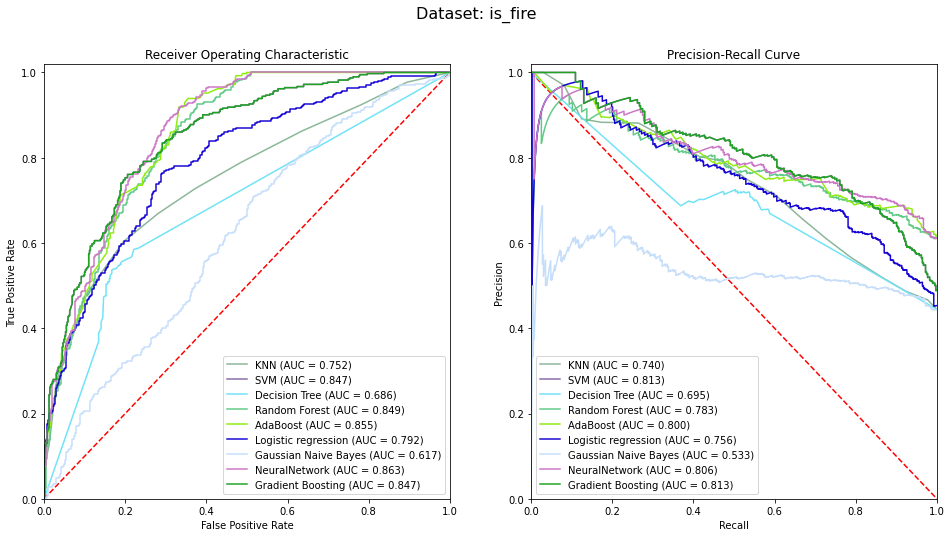

is_fire KNN
Precision score 0.8029556650246306
Recall score 0.41475826972010177
F1-score score 0.5469798657718121
Accuracy score 0.6945701357466063
is_fire SVM
Precision score 0.839622641509434
Recall score 0.4529262086513995
F1-score score 0.5884297520661157
Accuracy score 0.7183257918552036
is_fire Decision Tree
Precision score 0.72
Recall score 0.5038167938931297
F1-score score 0.5928143712574849
Accuracy score 0.6923076923076923
is_fire Random Forest
Precision score 0.7890295358649789
Recall score 0.4758269720101781
F1-score score 0.5936507936507937
Accuracy score 0.7104072398190046
is_fire AdaBoost
Precision score 0.7887931034482759
Recall score 0.46564885496183206
F1-score score 0.5855999999999999
Accuracy score 0.7070135746606335
is_fire Logistic regression
Precision score 0.8527131782945736
Recall score 0.27989821882951654
F1-score score 0.421455938697318
Accuracy score 0.6583710407239819
is_fire Gaussian Naive Bayes
Precision score 0.5270935960591133
Recall score 0.54452926208

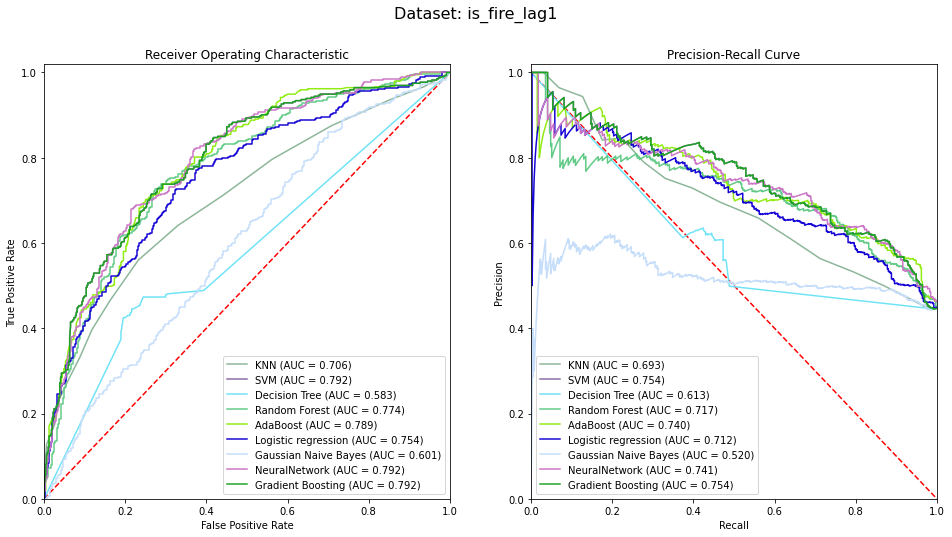

is_fire_lag1 KNN
Precision score 0.7514450867052023
Recall score 0.33078880407124683
F1-score score 0.4593639575971732
Accuracy score 0.6538461538461539
is_fire_lag1 SVM
Precision score 0.8268156424581006
Recall score 0.37659033078880405
F1-score score 0.5174825174825175
Accuracy score 0.6877828054298643
is_fire_lag1 Decision Tree
Precision score 0.6268656716417911
Recall score 0.42748091603053434
F1-score score 0.508320726172466
Accuracy score 0.6323529411764706
is_fire_lag1 Random Forest
Precision score 0.755656108597285
Recall score 0.42493638676844786
F1-score score 0.5439739413680781
Accuracy score 0.6832579185520362
is_fire_lag1 AdaBoost
Precision score 0.8020304568527918
Recall score 0.4020356234096692
F1-score score 0.535593220338983
Accuracy score 0.6900452488687783
is_fire_lag1 Logistic regression
Precision score 0.8508771929824561
Recall score 0.24681933842239187
F1-score score 0.3826429980276135
Accuracy score 0.6459276018099548
is_fire_lag1 Gaussian Naive Bayes
Precision s

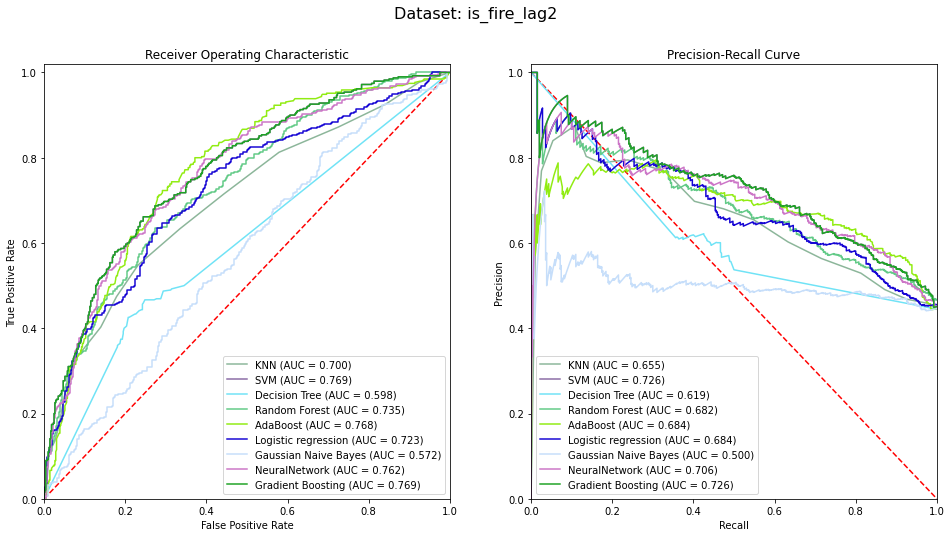

is_fire_lag2 KNN
Precision score 0.7678571428571429
Recall score 0.33076923076923076
F1-score score 0.4623655913978494
Accuracy score 0.6579247434435576
is_fire_lag2 SVM
Precision score 0.8053691275167785
Recall score 0.3076923076923077
F1-score score 0.4452690166975881
Accuracy score 0.6590649942987458
is_fire_lag2 Decision Tree
Precision score 0.6190476190476191
Recall score 0.4
F1-score score 0.485981308411215
Accuracy score 0.6237172177879133
is_fire_lag2 Random Forest
Precision score 0.7317073170731707
Recall score 0.38461538461538464
F1-score score 0.5042016806722689
Accuracy score 0.6636259977194983
is_fire_lag2 AdaBoost
Precision score 0.7553191489361702
Recall score 0.3641025641025641
F1-score score 0.4913494809688581
Accuracy score 0.6647662485746865
is_fire_lag2 Logistic regression
Precision score 0.7909090909090909
Recall score 0.2230769230769231
F1-score score 0.34800000000000003
Accuracy score 0.6282782212086659
is_fire_lag2 Gaussian Naive Bayes
Precision score 0.50389610

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (317) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


clf8 MLPClassifier(hidden_layer_sizes=(100, 50, 10),
              learning_rate_init=0.003744067519636624, max_iter=317,
              random_state=0)
Training GradientBoosting ...
clf9 GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)


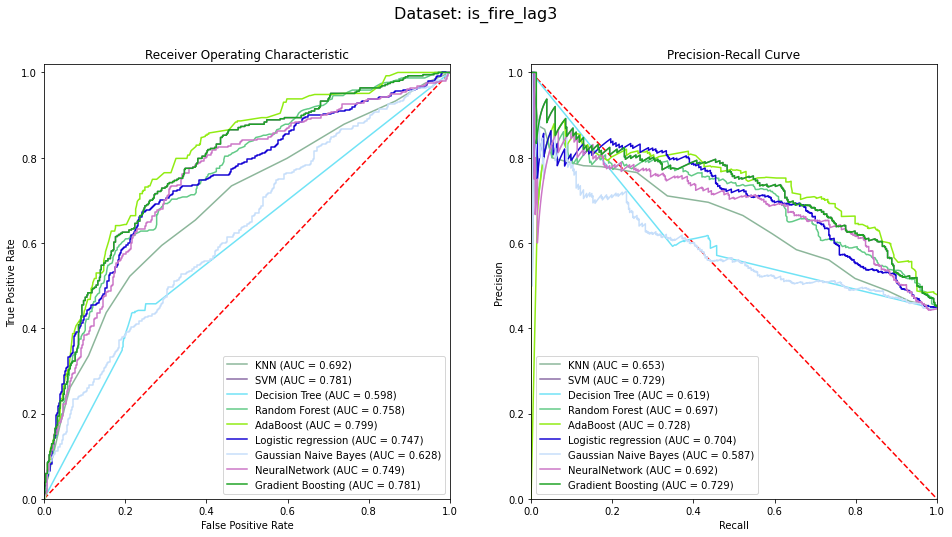

is_fire_lag3 KNN
Precision score 0.7103825136612022
Recall score 0.3359173126614987
F1-score score 0.456140350877193
Accuracy score 0.6436781609195402
is_fire_lag3 SVM
Precision score 0.7784431137724551
Recall score 0.3359173126614987
F1-score score 0.4693140794223827
Accuracy score 0.6620689655172414
is_fire_lag3 Decision Tree
Precision score 0.6065573770491803
Recall score 0.38242894056847543
F1-score score 0.46909667194928684
Accuracy score 0.6149425287356322
is_fire_lag3 Random Forest
Precision score 0.7653061224489796
Recall score 0.3875968992248062
F1-score score 0.5145797598627788
Accuracy score 0.674712643678161
is_fire_lag3 AdaBoost
Precision score 0.7783018867924528
Recall score 0.4263565891472868
F1-score score 0.5509181969949917
Accuracy score 0.6908045977011494
is_fire_lag3 Logistic regression
Precision score 0.8188976377952756
Recall score 0.268733850129199
F1-score score 0.4046692607003891
Accuracy score 0.6482758620689655
is_fire_lag3 Gaussian Naive Bayes
Precision scor

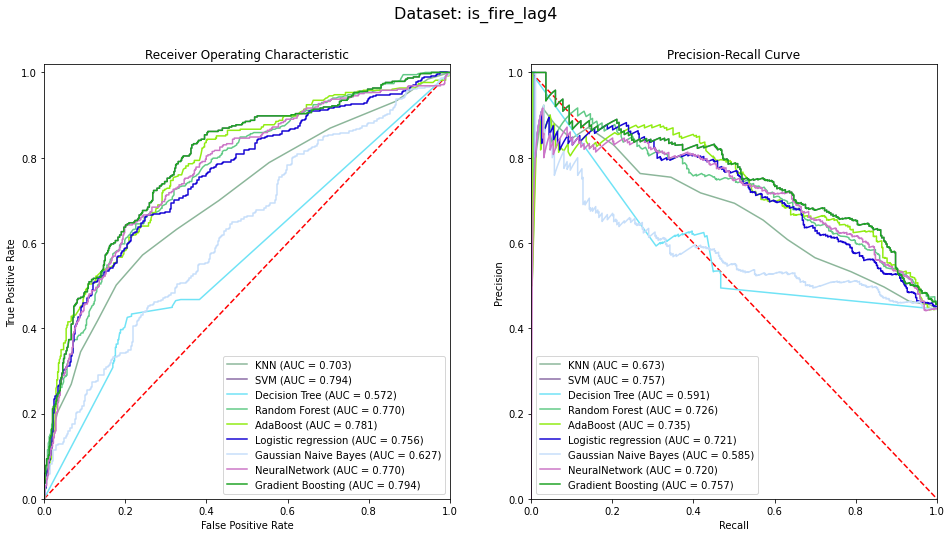

is_fire_lag4 KNN
Precision score 0.7542857142857143
Recall score 0.34464751958224543
F1-score score 0.4731182795698925
Accuracy score 0.6585365853658537
is_fire_lag4 SVM
Precision score 0.8333333333333334
Recall score 0.3394255874673629
F1-score score 0.4823747680890538
Accuracy score 0.6759581881533101
is_fire_lag4 Decision Tree
Precision score 0.6206896551724138
Recall score 0.37597911227154046
F1-score score 0.4682926829268293
Accuracy score 0.6202090592334495
is_fire_lag4 Random Forest
Precision score 0.8011363636363636
Recall score 0.3681462140992167
F1-score score 0.5044722719141324
Accuracy score 0.6782810685249709
is_fire_lag4 AdaBoost
Precision score 0.8341968911917098
Recall score 0.42036553524804177
F1-score score 0.5590277777777778
Accuracy score 0.7049941927990708
is_fire_lag4 Logistic regression
Precision score 0.8455284552845529
Recall score 0.27154046997389036
F1-score score 0.41106719367588934
Accuracy score 0.6538908246225319
is_fire_lag4 Gaussian Naive Bayes
Precisio

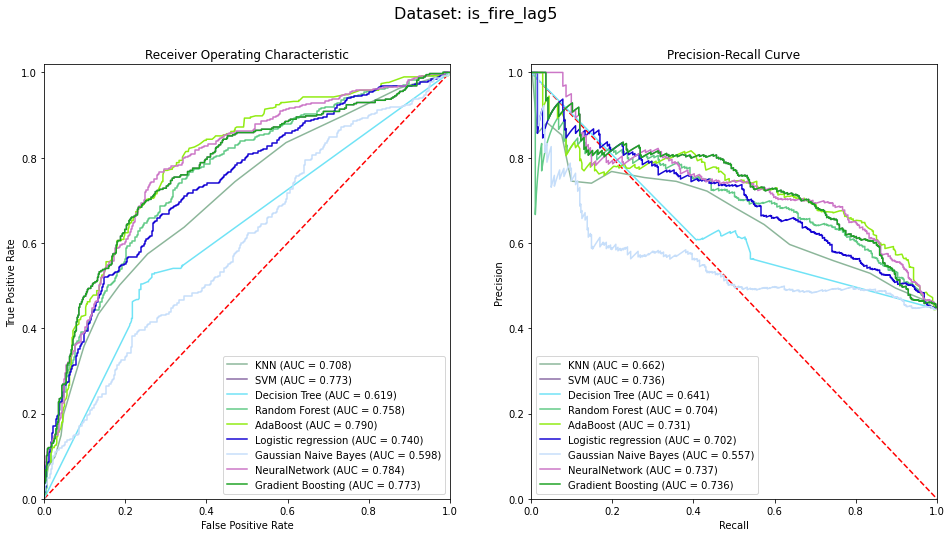

is_fire_lag5 KNN
Precision score 0.7445652173913043
Recall score 0.3577023498694517
F1-score score 0.48324514991181655
Accuracy score 0.6596980255516841
is_fire_lag5 SVM
Precision score 0.8047337278106509
Recall score 0.35509138381201044
F1-score score 0.49275362318840576
Accuracy score 0.6747967479674797
is_fire_lag5 Decision Tree
Precision score 0.6164383561643836
Recall score 0.4699738903394256
F1-score score 0.5333333333333333
Accuracy score 0.6341463414634146
is_fire_lag5 Random Forest
Precision score 0.7548076923076923
Recall score 0.40992167101827676
F1-score score 0.5313028764805415
Accuracy score 0.6782810685249709
is_fire_lag5 AdaBoost
Precision score 0.7892156862745098
Recall score 0.42036553524804177
F1-score score 0.5485519591141398
Accuracy score 0.6922183507549361
is_fire_lag5 Logistic regression
Precision score 0.7954545454545454
Recall score 0.2741514360313316
F1-score score 0.4077669902912621
Accuracy score 0.645760743321719
is_fire_lag5 Gaussian Naive Bayes
Precision

In [59]:
# %%time
#files = [file11, file1,file2,file3,file3_2,file3_3,file4,file5,file6,file7,file8,file9,file10]
#dfs = [df1,df2,df3,df3_2,df3_3,df4,df5,df6,df7,df8,df9,df10]
#dfs_test = [None,None,None,None,None,None,None,None,None,df7_test,None,None,None]

files = [df11[0].columns[-1], df11[1].columns[-1], df11[2].columns[-1], df11[3].columns[-1], df11[4].columns[-1], df11[5].columns[-1]]
dfs = [df11[0], df11[1], df11[2], df11[3], df11[4], df11[5]]
#dfs_test = [None, None, None, None, None, None]
dfs_test = [df12[0], df12[1], df12[2], df12[3], df12[4], df12[5]]


clfs_all_roc_scores = dict()
clfs_all_pr_scores = dict()
clfs_all_scores = pd.DataFrame()

# i = 0
# files=[files[i]]
# dfs = [dfs[i]]
# dfs_test = [dfs_test[i]]

for file,df,df_test in zip(files,dfs,dfs_test):
    roc_scores, pr_scores, clf_scores = make_classification(file, df, df_test)
    for k,v in roc_scores.items():
        if k not in clfs_all_roc_scores:
            clfs_all_roc_scores[k] = list()
        clfs_all_roc_scores[k].append(v)
    for k,v in pr_scores.items():
        if k not in clfs_all_pr_scores:
            clfs_all_pr_scores[k] = list()
        clfs_all_pr_scores[k].append(v)

    clfs_all_scores = clfs_all_scores.append(clf_scores, ignore_index=True)


In [60]:
clfs_all_scores.to_csv('dataset/' + 'clfs_all_scores_test_bef_2013.csv')


6

In [134]:
pd.DataFrame(clfs_all_roc_scores).to_csv('dataset/' + 'clfs_all_roc_scores_test_bef_2013.csv')
pd.DataFrame(clfs_all_pr_scores).to_csv('dataset/' + 'clfs_all_pr_scores_test_bef_2013.csv')


In [ ]:
clf_score

In [65]:
type(df)

pandas.core.frame.DataFrame

In [10]:
for k,v in clfs_all_roc_scores.items():
    print('%s-roc:'%k,["%.3f"%i for i in v])

KNN-roc: ['0.699', '0.717', '0.989', '0.985', '0.551', '0.503', '0.688', '0.913', '0.857', '0.923', '0.540', '0.617']
SVM-roc: ['0.788', '0.710', '0.988', '0.999', '0.594', '0.531', '0.749', '0.965', '0.884', '0.938', '0.502', '0.510']
Decision Tree-roc: ['0.596', '0.590', '0.931', '0.917', '0.550', '0.552', '0.616', '0.826', '0.733', '0.725', '0.542', '0.583']
Random Forest-roc: ['0.747', '0.743', '0.994', '0.996', '0.508', '0.624', '0.786', '0.973', '0.902', '0.938', '0.679', '0.761']
AdaBoost-roc: ['0.719', '0.754', '0.987', '0.995', '0.639', '0.610', '0.744', '0.748', '0.907', '0.770', '0.611', '0.792']
Logistic regression-roc: ['0.826', '0.712', '0.995', '0.982', '0.741', '0.562', '0.763', '0.952', '0.850', '0.931', '0.581', '0.753']
Gaussian Naive Bayes-roc: ['0.678', '0.713', '0.976', '0.983', '0.527', '0.601', '0.759', '0.918', '0.857', '0.711', '0.630', '0.751']
NeuralNetwork-roc: ['0.752', '0.697', '0.995', '0.969', '0.737', '0.464', '0.709', '0.969', '0.895', '0.935', '0.388

In [11]:
for k,v in clfs_all_pr_scores.items():
    print('%s-pr:'%k,["%.3f"%i for i in v])

KNN-pr: ['0.761', '0.466', '0.977', '0.985', '0.333', '0.693', '0.442', '0.782', '0.661', '0.623', '0.217', '0.092']
SVM-pr: ['0.835', '0.522', '0.977', '0.999', '0.401', '0.698', '0.560', '0.845', '0.732', '0.643', '0.177', '0.082']
Decision Tree-pr: ['0.733', '0.432', '0.938', '0.901', '0.367', '0.798', '0.534', '0.723', '0.638', '0.529', '0.288', '0.217']
Random Forest-pr: ['0.799', '0.515', '0.990', '0.994', '0.358', '0.740', '0.627', '0.879', '0.768', '0.646', '0.249', '0.162']
AdaBoost-pr: ['0.752', '0.508', '0.981', '0.992', '0.318', '0.739', '0.524', '0.300', '0.784', '0.218', '0.202', '0.180']
Logistic regression-pr: ['0.874', '0.513', '0.991', '0.981', '0.518', '0.698', '0.535', '0.792', '0.672', '0.607', '0.211', '0.171']
Gaussian Naive Bayes-pr: ['0.744', '0.466', '0.957', '0.974', '0.282', '0.721', '0.499', '0.692', '0.671', '0.167', '0.230', '0.150']
NeuralNetwork-pr: ['0.809', '0.397', '0.992', '0.979', '0.443', '0.685', '0.479', '0.859', '0.744', '0.626', '0.122', '0.16

In [ ]:
for k,v in clfs_all_roc_scores.items():
    print('%s avg roc_auc: %.2f, avg pr_auc: %.2f'%(k,np.mean(v),np.mean(clfs_all_pr_scores[k])))